In [1]:
# motion artefacts: ?
# bias: compare to N4ITK and a model we trained for a previous project
# noise: find a denoising algorithm
# super-resolution: evaluate against bilinear interpolation and maybe a machine learning method

In [2]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom
from scipy import ndimage
import random
from gstools import SRF, Gaussian
from scipy.fftpack import dct, idct
import os
from sklearn.metrics import mean_squared_error
from sewar.full_ref import vifp
import time
import SimpleITK as sitk

In [3]:
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
# data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2233,MP Pelvis_2233,MP\CT.2.25.168430369902691384448665480955143203741.dcm"

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

## Bias: N4ITK

In [4]:
# functions for bias

# 2D discrete cosine transform
def dct2(grid):   
    # discrete cosine transform
    M = grid.shape[0]
    N = grid.shape[1]
    a = np.empty([M,M],float)
    b = np.empty([M,M],float)
    for i in range(M):
        a[i,:] = dct(grid[i,:], norm='ortho')
    for j in range(N):
        b[:,j] = dct(a[:,j], norm='ortho')
    
    # keep essential DCT coefficients
    b = b[:M, :N]
    
    # inverse discrete cosine transform
    m = b.shape[0]
    n = b.shape[1]
    M = 320
    N = 320
    a = np.empty([m,N],float)
    grid = np.empty([M,N],float)
    for i in range(m):
        a[i,:] = idct(b[i,:], n=M, norm='ortho')
    for j in range(N):
        grid[:,j] = idct(a[:,j], n=N, norm='ortho')
        
    return grid

def GetFields(image):    
    down_size = np.int32(np.divide(image.shape, 10))
    x = np.arange(down_size[0])
    y = np.arange(down_size[1])
    
    len_scale = np.random.uniform(10, 50)
    model = Gaussian(dim=2, var=50, len_scale=len_scale)

    srf = SRF(model)

    grid_z = srf((x, y), mesh_type='structured')
    grid_z = dct2(grid_z)
    
    bias_rng = 1.00 #np.random.uniform(0.20, 1.00)
    grid_z = np.interp(grid_z, (grid_z.min(), grid_z.max()),
                       (1 - bias_rng / 2, 1 + bias_rng / 2))
    
    return grid_z

In [5]:
image = (image - np.min(image)) / (np.max(image) - np.min(image))
bias = GetFields(image)
img = np.multiply(image, bias)
#img = (img - np.mean(img)) / np.std(img)
img = (img - np.min(img)) / (np.max(img) - np.min(img))

In [6]:
#https://simpleitk.readthedocs.io/en/release/link_N4BiasFieldCorrection_docs.html

#inputImage = sitk.ReadImage(r"C:\Users\simon\OneDrive - TU Eindhoven\Documents\GitHub\artefacts\figures\bias2.dcm", sitk.sitkFloat32)
#inputImage = img
inputImage = sitk.GetImageFromArray(img)
inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)

#image = inputImage

maskImage = sitk.OtsuThreshold(inputImage, 0, 1, 200)


corrector = sitk.N4BiasFieldCorrectionImageFilter()

numberFittingLevels = 4

corrected_image = corrector.Execute(inputImage, maskImage)

log_bias_field = corrector.GetLogBiasFieldAsImage(inputImage)

bias_field = inputImage / sitk.Exp(log_bias_field)

#castFilter = sitk.CastImageFilter()
#castFilter.SetOutputPixelType(sitk.sitkInt16)

#imgFiltered = castFilter.Execute(corrected_image)

img2 = sitk.GetArrayFromImage(corrected_image)
#sitk.WriteImage(imgFiltered, r"C:\Users\simon\OneDrive - TU Eindhoven\Documents\GitHub\artefacts\figures\bias_corrected2.dcm")

(-0.5, 319.5, 319.5, -0.5)

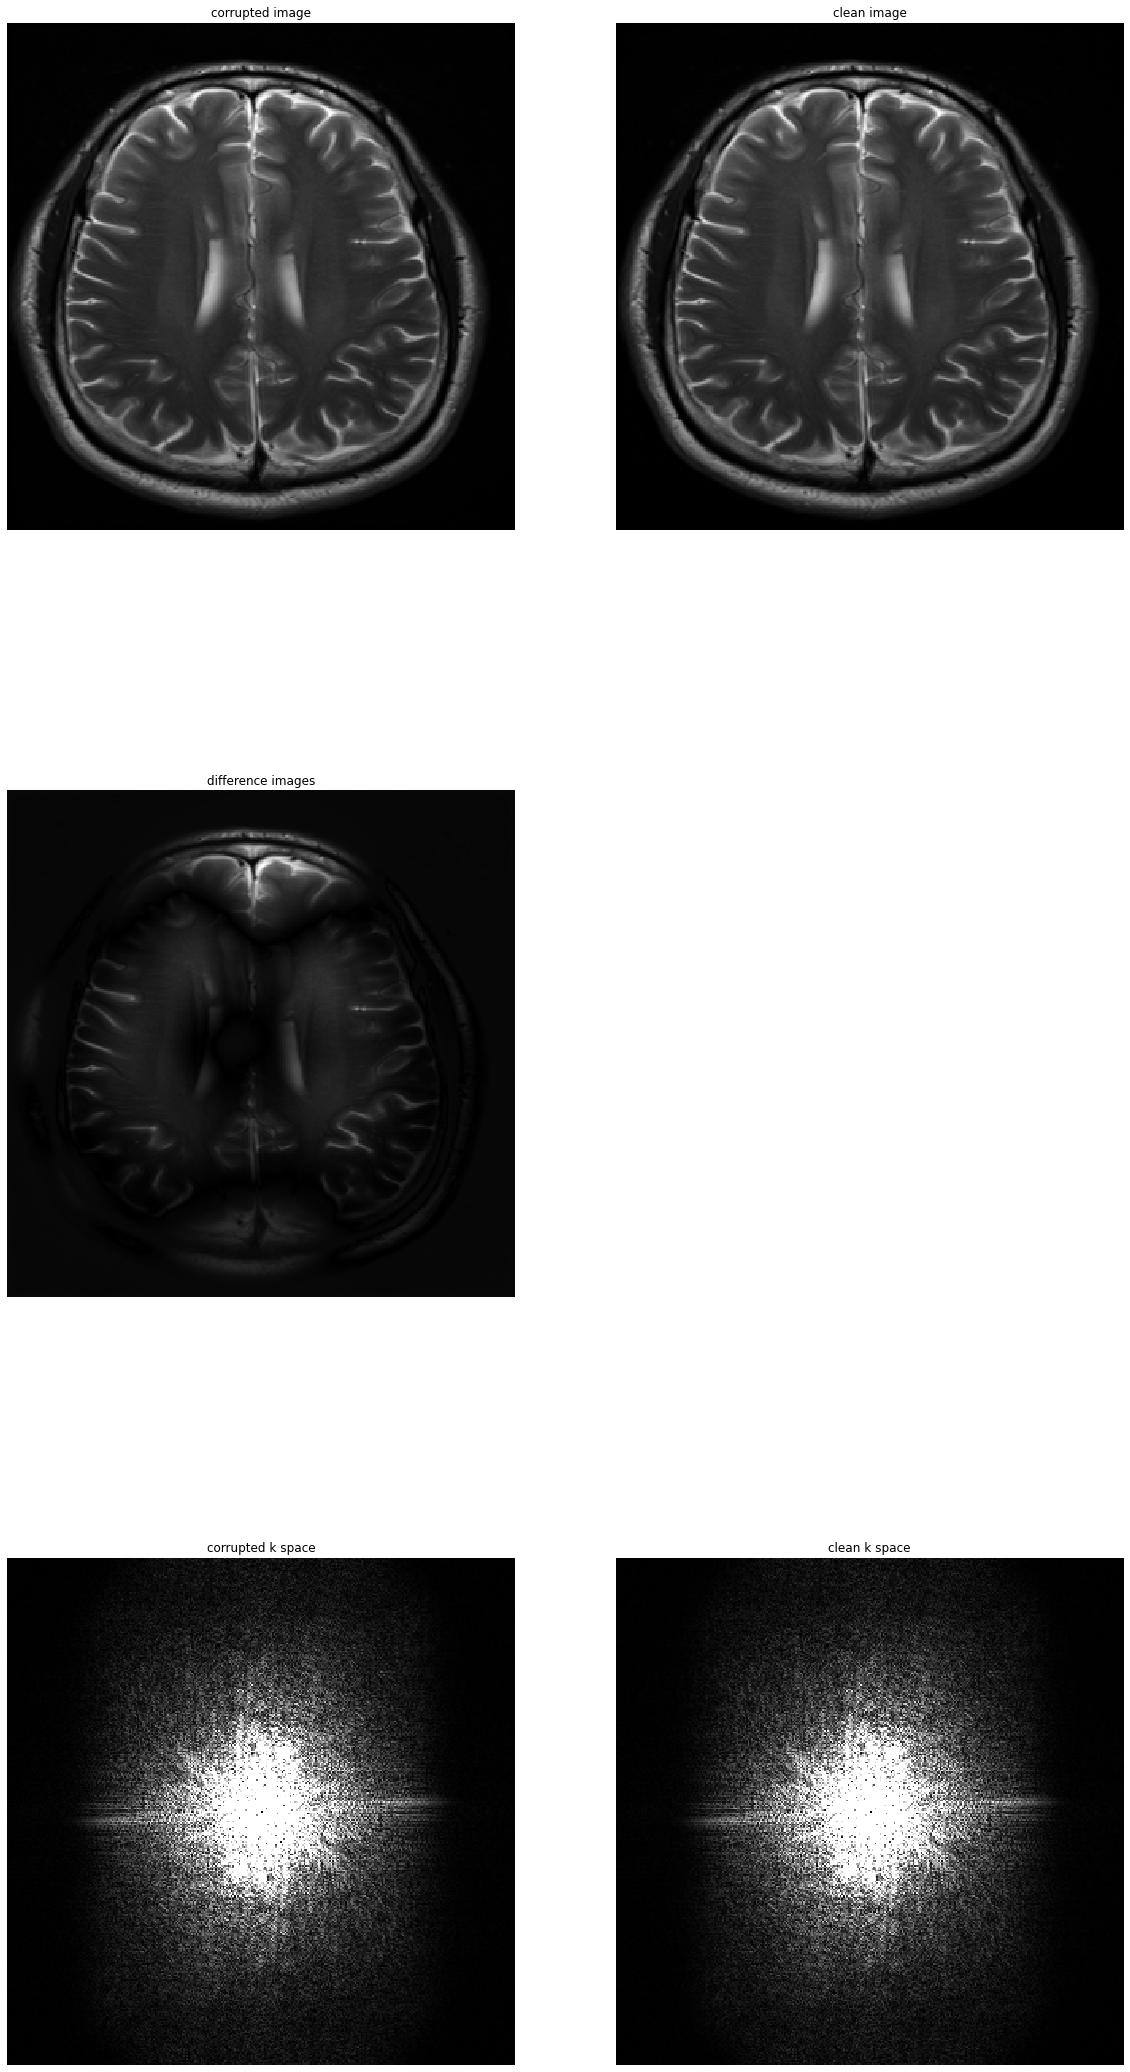

In [7]:
# plotting
from utils import transform_image_to_kspace, transform_kspace_to_image

hr = img2
hr = (hr - np.mean(hr)) / np.std(hr)
lr = img
lr = (lr - np.mean(lr)) / np.std(lr)

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)  #vmin=0.5, vmax=1 / 0.5
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

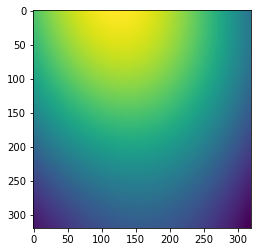

In [8]:
plt.imshow(bias)

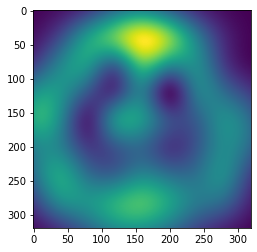

In [9]:
bias_field_array = sitk.GetArrayFromImage(log_bias_field)
plt.imshow(bias_field_array)

## Noise: bm3d